In [1]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('float_format', '{:f}'.format)
dataframes = {}

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


ibm_prod_trace = pd.read_json('trace/prod-dal09-logstash-2017.07.21-2.json')
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.method'] == 'GET') | (ibm_prod_trace['http.request.method'] == 'PUT')]
#ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.request.method'] == 'GET']
ibm_prod_trace = ibm_prod_trace.sort_values(by=['timestamp'])
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.uri'].str.contains('manifest')) | (ibm_prod_trace['http.request.uri'].str.contains('blobs'))]
ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.response.written'] > 0]
ibm_prod_trace['timestamp'] = ibm_prod_trace['timestamp'] - ibm_prod_trace['timestamp'].iloc[0]
ibm_prod_trace['timestamp'] = ibm_prod_trace['timestamp'].dt.total_seconds()
ibm_prod_trace = ibm_prod_trace[:405]
ibm_prod_trace = ibm_prod_trace[['http.request.duration', 'http.request.method', 'http.request.uri', 'http.response.written', 'timestamp']]
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('manifest'), 'document_type'] = 'manifest'
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('blobs'), 'document_type'] = 'layer'
ibm_prod_trace = ibm_prod_trace.rename(columns={'timestamp': 'time', 'http.request.method': 'method', 'http.response.written': 'size', 'http.request.duration': 'duration'})
ibm_prod_trace = ibm_prod_trace[['duration', 'method', 'size', 'time', 'document_type']]
ibm_prod_trace = ibm_prod_trace.astype({'size': 'int64'})


Data = { 'Registry': [], 'avg_latency_put': [], 'avg_latency_get': [], 'avg_latency_manifest_get': [], 'avg_latency_layer_get': [], 'avg_throughput': [], 'throughput_data': [] }

In [2]:
dataframe_ecr_eu_west = pd.read_json('results/results-no-wait-5gb/133132736141.dkr.ecr.eu-west-1.amazonaws.com-results.json')
dataframe_ecr_eu_central = pd.read_json('results/results-no-wait-5gb/133132736141.dkr.ecr.eu-central-1.amazonaws.com-results.json')
dataframe_ecr_us_west = pd.read_json('results/results-no-wait-5gb/133132736141.dkr.ecr.us-west-1.amazonaws.com-results.json')
dataframe_ecr_us_east = pd.read_json('results/results-no-wait-5gb/133132736141.dkr.ecr.us-east-1.amazonaws.com-results.json')
gcr_asia =pd.read_json('results/results-no-wait-5gb/asia.gcr.io-results.json')
gcr_eu = pd.read_json('results/results-no-wait-5gb/eu.gcr.io-results.json')
gcr_us = pd.read_json('results/results-no-wait-5gb/us.gcr.io-results.json')
acr_premium_eu_west = pd.read_json('results/results-no-wait-5gb/premiumregistrybenchmark.azurecr.io-results.json')
acr_standard_eu_west = pd.read_json('results/results-no-wait-5gb/registrybenchmark.azurecr.io-results.json')
acr_basic_eu_west = pd.read_json('results/results-no-wait-5gb/basicregistrybenchmark.azurecr.io-results.json')
acr_premium_eu_central = pd.read_json('results/results-no-wait-5gb/premiumregistryeucentral.azurecr.io-results.json')
acr_standard_eu_central = pd.read_json('results/results-no-wait-5gb/standardregistryeucentral.azurecr.io-results.json')
acr_standard_us_east = pd.read_json('results/results-no-wait-5gb/standardregistryuseast.azurecr.io-results.json')
acr_standard_us_west = pd.read_json('results/results-no-wait-5gb/standardregistryuswest.azurecr.io-results.json')
ibm_registry_dallas = pd.read_json('results/results-no-wait-5gb/us.icr.io-results.json')
docker_registry = pd.read_json('results/results-no-wait-5gb/registry-1.docker.io-results.json')

dataframes_nowait = {}
dataframes_nowait['ibm-registry-dallas'] = ibm_registry_dallas
dataframes_nowait['ecr-eu-west'] = dataframe_ecr_eu_west
dataframes_nowait['ecr-eu-central'] = dataframe_ecr_eu_central
dataframes_nowait['ecr-us-west'] = dataframe_ecr_us_west
dataframes_nowait['ecr-us-east'] = dataframe_ecr_us_east
dataframes_nowait['gcr-eu'] = gcr_eu
dataframes_nowait['gcr-us'] = gcr_us
dataframes_nowait['gcr-asia'] = gcr_asia
dataframes_nowait['acr-premium-eu-west'] = acr_premium_eu_west
dataframes_nowait['acr-standard-eu-west'] = acr_standard_eu_west
dataframes_nowait['acr-basic-eu-west'] = acr_basic_eu_west
dataframes_nowait['acr-standard-us-east'] = acr_standard_us_east
dataframes_nowait['acr-standard-us-west'] = acr_standard_us_west
# dataframes_nowait['acr-standard-eu-central'] = acr_standard_eu_central
# dataframes_nowait['acr-premium-eu-central'] = acr_premium_eu_central
dataframes_nowait['docker-hub'] = docker_registry


dataframes = dataframes_nowait

Data = { 'Registry': [], 'avg_latency_put': [], 'avg_latency_get': [], 'avg_latency_manifest_get': [], 'avg_latency_layer_get': [], 'avg_throughput': [], 'throughput_data': [], 'failed_request_count': [] }

ibm-registry-dallas
ecr-eu-west
ecr-eu-central
ecr-us-west
ecr-us-east
gcr-eu
gcr-us
gcr-asia
acr-premium-eu-west
acr-standard-eu-west
acr-basic-eu-west
acr-standard-us-east
acr-standard-us-west
docker-hub


Text(0.5, 0, 'Time (seconds)')

<Figure size 432x288 with 0 Axes>

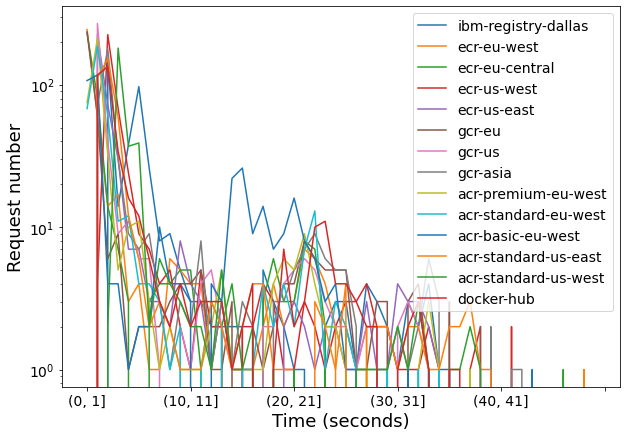

In [3]:
for dataframe in dataframes:
    print(dataframe)
    failed_request_count = len(dataframes[dataframe][dataframes[dataframe]['onTime'] == 'failed'].index)
    dataframes[dataframe] = dataframes[dataframe][dataframes[dataframe]['onTime'] != 'failed']
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['time'])
    dataframes[dataframe]["time"] = dataframes[dataframe]["time"] - dataframes[dataframe]["time"].iloc[0]
    dataframes[dataframe]["arrival_time"] = dataframes[dataframe]["time"] + dataframes[dataframe]["duration"]
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['arrival_time'])
    requests_get = dataframes[dataframe][dataframes[dataframe]["method"] == "GET"]["duration"].mean()
    requests_put = dataframes[dataframe][dataframes[dataframe]["method"] == "PUT"]["duration"].mean()
    requests_get_layer = dataframes[dataframe][dataframes[dataframe]["document_type"] == "layer"]["duration"].mean()

    requests_get_manifest = dataframes[dataframe][dataframes[dataframe]["document_type"] == "manifest"]["duration"].mean()
    throughput = len(dataframes[dataframe].index) / dataframes[dataframe]['arrival_time'].iloc[-1]
    Data['Registry'].append(dataframe)
    Data['avg_latency_put'].append(requests_put)
    Data['avg_latency_get'].append(requests_get)
    Data['avg_latency_manifest_get'].append(requests_get_manifest)
    Data['avg_throughput'].append(throughput)
    Data['avg_latency_layer_get'].append(requests_get_layer)
    Data['failed_request_count'].append(failed_request_count)
    
    counters = dataframes[dataframe]['arrival_time'].groupby(pd.cut(dataframes[dataframe]['arrival_time'], np.arange(0,int(math.ceil(dataframes[dataframe]['arrival_time'].iloc[-1])),1))).count()
    Data['throughput_data'].append(counters)

df = pd.DataFrame({
    'ibm-registry-dallas': Data['throughput_data'][0],
    'ecr-eu-west': Data['throughput_data'][1],
    'ecr-eu-central': Data['throughput_data'][2],
    'ecr-us-west': Data['throughput_data'][3],
    'ecr-us-east': Data['throughput_data'][4],
    'gcr-eu': Data['throughput_data'][5],
    'gcr-us': Data['throughput_data'][6],
    'gcr-asia': Data['throughput_data'][7],
    'acr-premium-eu-west': Data['throughput_data'][8],
    'acr-standard-eu-west': Data['throughput_data'][9],
    'acr-basic-eu-west': Data['throughput_data'][10],
    'acr-standard-us-east': Data['throughput_data'][11],
    'acr-standard-us-west': Data['throughput_data'][12],
#     'acr-premium-eu-central': Data['throughput_data'][13],
#     'acr-standard-eu-central': Data['throughput_data'][14],
    'docker-hub': Data['throughput_data'][13]
})

df = df[:50]
plt.figure()
fig = df.plot(kind='line',logy=True, figsize=(10,7))
plt.ylabel('Request number')
plt.xlabel('Time (seconds)')

# plt.savefig('plots/3.5gb/stress/throughput-per-second-eu-log.png', bbox_inches='tight')

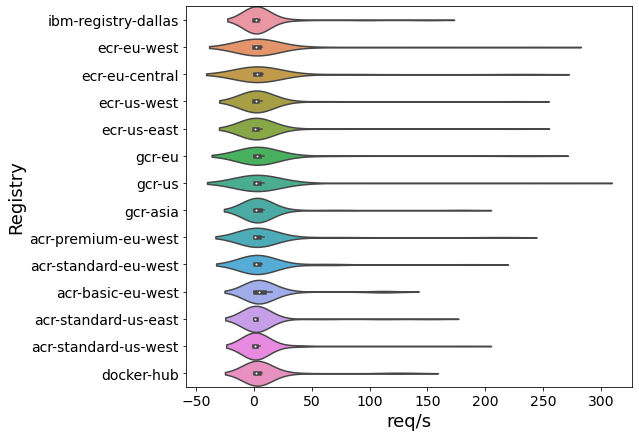

In [4]:

plt.figure(figsize=(8,7))
fig = sns.violinplot(data=df, width=1, orient="h")
plt.xlabel('req/s')
plt.ylabel('Registry')
plt.savefig('plots/3.5gb/stress/violin-throughput-per-sec.png', bbox_inches='tight')

<Figure size 360x360 with 0 Axes>

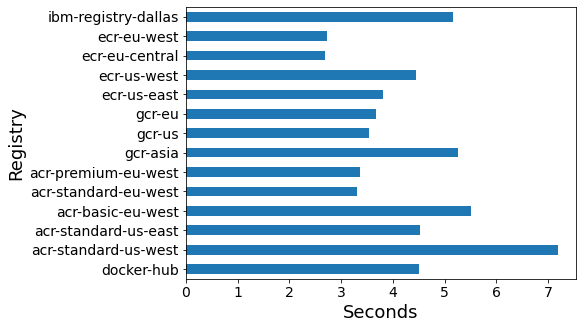

In [5]:
df = pd.DataFrame(Data,columns=['Registry','avg_latency_get'])
plt.figure(figsize=(5,5))
fig = df.plot(x='Registry', y='avg_latency_get', kind='barh', figsize=(7,5))
plt.xlabel('Seconds')
fig.get_legend().remove()
fig.invert_yaxis()
plt.savefig('plots/3.5gb/stress/avg_latency_get.png', bbox_inches='tight')

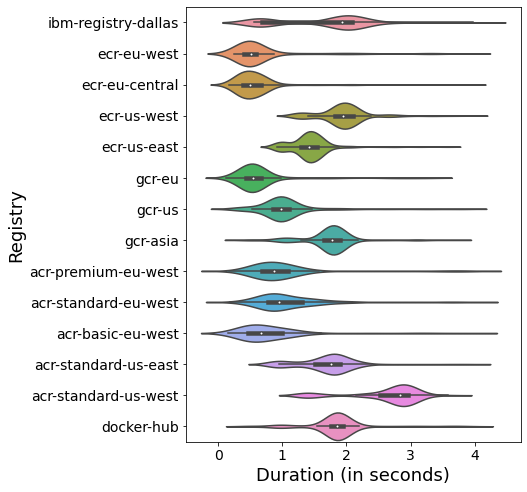

In [12]:
for dataframe in dataframes:
    dataframes[dataframe]['registry'] = dataframe
df = pd.concat(dataframes)
df_get = df[df['method'] == 'GET']
df_put = df[df['method'] == 'PUT']


# all_indices = []

# for x in range (len(df_get.index)):
#     all_indices.append(df_get.index[x][0])

# df_get.boxplot(by='registry', column='duration', figsize=(30,20), showfliers=False, vert=False)
# df_get['registry'] = all_indices
    
# df_get
# # print(df_get_melt)
df_get_filter = df_get[df_get.duration<4]
plt.figure(figsize=(6,8))
# df_get = df_get.loc[df_get.duration < 15]
fig = sns.violinplot(x="duration", y='registry', data=df_get_filter, vert=False, showfliers=False,showmeans=True, inner="box", width=1)
plt.xlabel('Duration (in seconds)')
plt.ylabel('Registry')
plt.savefig('plots/3.5gb/stress/violin_latency_get_boxplot.png', bbox_inches='tight')

<Figure size 360x360 with 0 Axes>

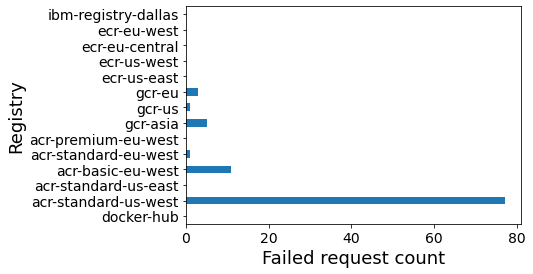

In [7]:

dataframe = pd.DataFrame(Data, columns=['Registry', 'failed_request_count'])
plt.figure(figsize=(5,5))
fig = dataframe.plot.barh(x='Registry')
fig.invert_yaxis()
plt.xlabel('Failed request count')
plt.ylabel('Registry')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/stress/failed_request_plot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

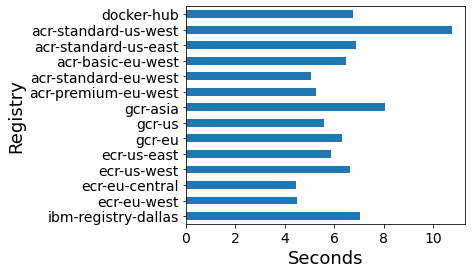

In [8]:
df_lay = pd.DataFrame(Data,columns=['Registry','avg_latency_layer_get'])
plt.figure()
fig = df_lay.plot(x='Registry', y='avg_latency_layer_get', kind='barh', figsize=(5, 4))
plt.ylabel('Registry')
plt.xlabel('Seconds')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/stress/latency_layer_get_bar.png', bbox_inches='tight')

ibm-registry-dallas  270   1.797897
                     271   1.941948
                     272   1.955882
                     1     1.902450
                     274   1.969117
                             ...   
docker-hub           258   0.535910
                     260   1.779132
                     130   3.313680
                     132   0.504779
                     262   0.499546
Name: duration, Length: 2083, dtype: float64


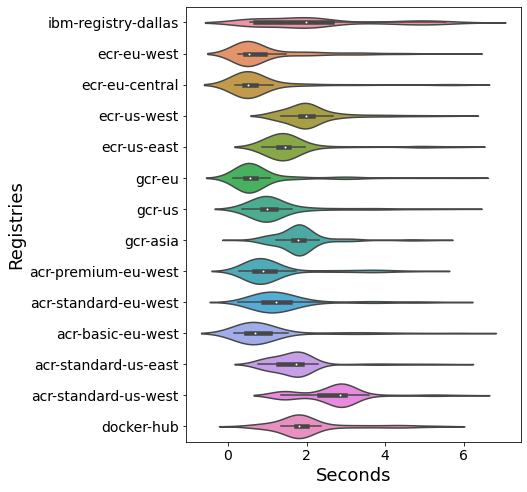

In [9]:
df_layer = df_get[df_get['document_type'] == 'layer']
df_layer_filter = df_layer[df_layer.duration < 6]
print(df_layer_filter['duration'])
plt.figure(figsize=(6,8))
p = sns.violinplot(data=df_layer_filter, x='duration', y='registry', width=1)
plt.xlabel('Seconds')
plt.ylabel('Registries')
plt.suptitle('')
plt.savefig('plots/3.5gb/stress/delay_latency_layer_get_violin.png', bbox_inches='tight')

time              0.941954
duration          4.467688
size           4819.420118
arrival_time      5.409642
errorType              nan
dtype: float64


<Figure size 432x288 with 0 Axes>

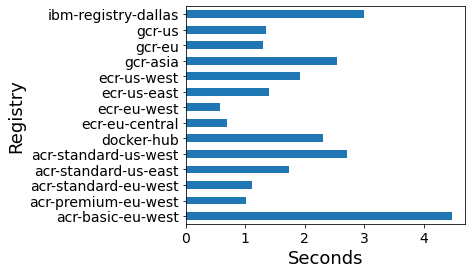

In [10]:
df_man = df_get[df_get['document_type'] == 'manifest']
print(df_man[df_man.registry == 'acr-basic-eu-west'].mean())
df = pd.DataFrame(Data,columns=['Registry','avg_latency_manifest_get'])
df_group = df_man.groupby('registry', as_index=False)['duration'].mean()
plt.figure()
fig = df_group.plot(x='registry', y='duration', kind='barh', figsize=(5,4))
plt.xlabel('Seconds')
plt.ylabel('Registry')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/stress/delay_avg_latency_manifest_get.png', bbox_inches='tight')

In [11]:

df_man = df_man[df_man.duration < 6]
print(df_man_filter.duration.mean())
plt.figure(figsize=(6,9))
p = sns.violinplot(data=df_man, x='duration', y='registry', width=1)
plt.xlabel('Seconds')
plt.suptitle('')
plt.ylabel('')
plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig('plots/3.5gb/stress/delay_latency_man_get_violin.png', bbox_inches='tight')

NameError: name 'df_man_filter' is not defined

In [ ]:
df = pd.DataFrame(Data,columns=['Registry','avg_throughput'])
plt.figure()
fig = df.plot(x='Registry', y='avg_throughput', kind='barh', figsize=(5,4))
plt.xlabel('req/s')
fig.invert_yaxis()
fig.get_legend().remove()
plt.savefig('plots/3.5gb/stress/avg_throughput.png', bbox_inches='tight')

In [ ]:

df = pd.DataFrame(Data,columns=['Registry','avg_latency_put'])
plt.figure()
fig = df.plot(x='Registry', y='avg_latency_put', kind='barh', figsize=(5,4))
plt.xlabel('Seconds')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/stress/avg_latency_put.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6,8))
# df_get = df_get.loc[df_get.duration < 15]
df_put_filter = df_put[df_put.duration < 20]
fig = sns.violinplot(x="duration", y='registry', data=df_put_filter, vert=False, showfliers=False,showmeans=True, inner="box", width=1)
plt.xlabel('Duration (in seconds)')
plt.ylabel('Registry')
plt.savefig('plots/3.5gb/stress/violin_latency_put_boxplot.png', bbox_inches='tight')